# Overview

Currently the website has a static image of a cat on the home page. The cat is not smiling and looks rather sad. Next to the photo there is a CTA button saying "Adopt today" which would direct the user to a adoption application form.

Our goal is to design a AB test to so we can understand if changing a photo on the landing page will increase conversions in users clicking the button. The scenario is we are analyzing the conversions for a pet adoption site.

For this experiment we will simply change the original cat photo, into a photo where the cat is smiling. Our hypothesis is 
"Changing the cat from a sad to happy photo will result in more people clicking on the "Adopt today" button".

## Exploring Current Conversions
First we will explore the current conversions on the site to get baseline conversion rates for our analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# read in click data
click_data = pd.read_csv("click_data.csv")
click_data.head()

,visit_date,clicked_adopt_today
0,2017-01-01,1
1,2017-01-02,1
2,2017-01-03,0
3,2017-01-04,1
4,2017-01-05,1


Now that we know the type of data we have we can look at the date range.

In [3]:
#earliest date
click_data['visit_date'].min()

'2017-01-01'

In [4]:
#earliest date
click_data['visit_date'].max()

'2017-12-31'

We can see that the minimum visit date is January 1 2017, and latest visit date is December 31, 2017. So we have values for the entire year.

### Baseline Conversions

Get the current conversion rate so we know what compare. We need to decide what timeseries we want group our conversions.


In [5]:
# convert string to date
click_data['visit_date'] = pd.to_datetime(click_data['visit_date'])

In [6]:
# check if we got it
click_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
visit_date             3650 non-null datetime64[ns]
clicked_adopt_today    3650 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 57.2 KB


In [7]:
# annual average conversion
click_data['clicked_adopt_today'].mean()

0.2772602739726027

We see that the average baseline conversion rate through out the year is 28%. We can explore this further by looking into more granular conversion rates.

### Weekday

In [8]:
# get weekday
click_data['weekday'] = click_data['visit_date'].dt.weekday

In [9]:
# find the conversion rates by weekday
click_data.groupby(['weekday'])['clicked_adopt_today'].agg('mean')

weekday
0    0.276923
1    0.271154
2    0.298077
3    0.271154
4    0.267308
5    0.255769
6    0.300000
Name: clicked_adopt_today, dtype: float64

The weekday 6 is Sunday and has the highest conversion rate at 30%, with Saturday having the lowest at 25.5%.

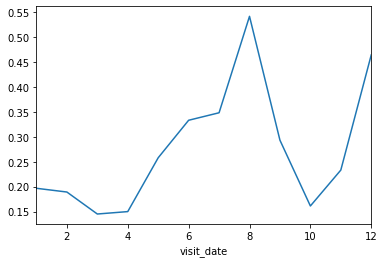

In [10]:
# week
click_data.groupby([click_data['visit_date'].dt.month])['clicked_adopt_today'].agg('mean').plot()

In [11]:
monthly_conversions = click_data.groupby([click_data['visit_date'].dt.month])['clicked_adopt_today'].agg('mean')

Looking at the monthly conversion there is a clear spike around June going into August, then a steep decline in September. This could tell us that people are clicking on the button more in the summer.

In [12]:
# # get weekday
# click_data['week'] = click_data['visit_date'].dt.week

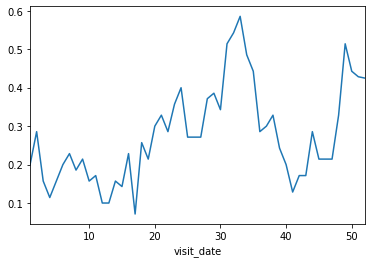

In [13]:
# week
click_data.groupby([click_data['visit_date'].dt.week])['clicked_adopt_today'].agg('mean').plot()

In [14]:
weekly_conversions = click_data.groupby([click_data['visit_date'].dt.week])['clicked_adopt_today'].agg('mean')

Going into more detail we can see the changes in the weeks throughout the year.

## Building the Experiment

When we look to create our control and test group we want to make sure we are accounting for factors such as seasonality. We see in our data that the summer would be when most conversion occurred.

We want to run the test and control simultaneously. Depending on we choose to run the AB test we will have different baseline conversions.

For example the conversions would be as follows if we were running it in:

    January - 20%
    July    - 33%
    August  - 54%
    October - 16%

As we can see there is a lot of fluctuations in our current conversions so we will want to take into account - POWER ANALYSIS.

## Power
How long do we run the experiment? 

    - Too short and we don't get enough insights
    - Too long and we may be wasting resources
    
Power Analysis will tell you how many data points or sample size do we need to know to ensure the effect is real. Once we have the sample size you can figure how long we need to run the experiment to get the required data points.

For Power Analysis we should know:

1. statistical test - statistical test we plan to run
2. baseline value - value for the current control condition
3. desired value - expected value for the test condition
4. proportion of the data from the test condition (ideally 0.5)
5. significance threshold / alpha = level where effect significant (generally 0.05)
6. power / 1 -beta = probability correctly rejecting null hypothesis (generally 0.8)

In [15]:
# function to obtain the power
from scipy import stats

def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2-p1)
    bp = (p1+p2) / 2
    
    v1 = p1 * (1-p1)
    v2 = p2 * (1-p2)
    bv = bp * (1-bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    
    power = power_part_one + power_part_two
    
    return (power)

In [16]:
#get sample size
def get_sample_size(power, p1, p2, cl, max_n=1000000):
    n = 1 
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)

        if tmp_power >= power: 
            return n 
        else: 
            n = n + 100

    return "Increase Max N Value"

## Which conversion rate to use?
Let's explore what the sample size would be if we choose the month with the highest conversion - August at 54%. 

### 10% conversion lift
Assuming we want a 10% lift in conversion we can use the formula below.

In [17]:
# power - 0.8 standard
# p1 - original conversion 0.54
# p2 - expected conversion 0.54 + 10%
# cl - confidence level with alpha 0.05 - cl = 0.95
get_sample_size(0.8, 0.54, 0.64, 0.95)

401

We now know if we ran the experiment in August we would need at least 401 data points or ~200 per group.

If we only expect a 5 percentage point conversion rate increase we need 1601 (about 800 per group) to see a significant effect, much more than if we predicted a 10 percentage point increase.

Now that we have the sample size we can run the experiment.

# Analyzing Results
We have run the test and obtained the results from our control and test group. We have the information in a new CSV and we can explore the results below. We decided

In [18]:
experiment_data = pd.read_csv("experiment_data.csv")

In [19]:
# size of the results
experiment_data.shape

(588, 3)

In [20]:
# convert string to date
experiment_data['visit_date'] = pd.to_datetime(experiment_data['visit_date'])

In [21]:
#check converting to datetime
experiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 3 columns):
visit_date        588 non-null datetime64[ns]
condition         588 non-null object
clicked_button    588 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 13.9+ KB


In [22]:
# conversions of control group grouped by day
control_conversions = pd.DataFrame(experiment_data[
                                experiment_data['condition']=='control'].groupby(
                                ['visit_date'])['clicked_button'].agg('mean')).reset_index()

# rename the columns
control_conversions.columns = ['date', 'conversions']

In [23]:
# conversions of test group grouped by day
test_conversions = pd.DataFrame(experiment_data[
                                experiment_data['condition']=='test'].groupby(
                                ['visit_date'])['clicked_button'].agg('mean')).reset_index()

# rename the columns
test_conversions.columns = ['date','conversions']

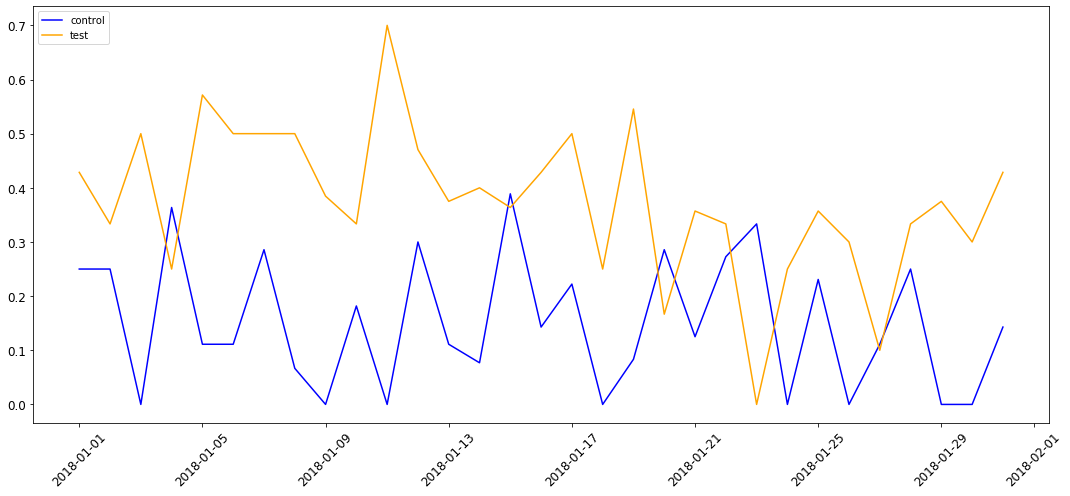

In [24]:
# plot the two lines in the same graph

plt.figure(figsize = (15,7))

# first plot for control
plt.plot('date', 'conversions', data = control_conversions, color = 'blue', label = 'control')
plt.plot('date', 'conversions', data = test_conversions, color = 'orange', label = 'test')
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


Looking at the results we can see that the test group performed better than the control group consistently over the entire month expect for a big drop around January 22 - 23.

## Logistic Regression
Let's continue the analysis by building a model to interpret the performance.

In [25]:
experiment_data.groupby(['condition'])['clicked_button'].agg('mean')

condition
control    0.166667
test       0.384354
Name: clicked_button, dtype: float64

We can see a clear difference in conversion rates. The control group had a rate of ~17%, while the test group had ~38%.

In [26]:
import statsmodels.formula.api as smf

# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ clicked_button ~ condition
                                        """,
                                        data    = experiment_data)

# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.558358
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         clicked_button   No. Observations:                  588
Model:                          Logit   Df Residuals:                      586
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:                 0.05148
Time:                        18:24:38   Log-Likelihood:                -328.31
converged:                       True   LL-Null:                       -346.13
Covariance Type:            nonrobust   LLR p-value:                 2.376e-09
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6094      0.156    -10.284      0.000      -1.916      -1.303
condition[T.test]     1.1383      0.197      5.774      0.000       0.752       1.525
=====================================================================================
"""

# Results
Looking at our results we can see the p-value is less than 0.05 our alpha so the results are still significant.

We can conclude that the new design on the landing page increased conversions, and we can roll it out to a larger population of our customers. For this we can determine that customers were accepting of the smiling cat photo and therefore went onto the next stage of clicking the button.

# Follow-Up Experiment

This is a continued project from our Pet adoption experiment.  In this experiment we will follow up with the new design we implemented and see if we can build on the image that was used - a cat smiling. 

Now, we want to see if an experiment that changes the smiling cat into a smiling kitten will improve conversion again.

Our hypothesis is "Changing the cat to a kitten will convert more users click on the "Adopt today" button".

From our previous experiment we saw that the increase in conversion was now ~38%. Going of intuition I believe that changing the photo from cat to kitten will have a significantly higher conversion. With that assumption I think the conversion rate will increase by 20% to 58%.

In [27]:
# let's get the sample size
get_sample_size(0.8, 0.38,x0.59, 0.95)

101

Turns out we only need 101 data points in total (~51 per group) since our expected effect is so large.

In [28]:
# read in our follow up results
experiment_data_2 = pd.read_csv("experiment_data_2.csv")

In [29]:
# convert to datetime
experiment_data_2['visit_date'] = pd.to_datetime(experiment_data_2['visit_date'])

In [30]:
# explore converisons by group
experiment_data_2.groupby(['condition'])['clicked_button'].agg('mean')

condition
cat       0.705882
kitten    0.793103
Name: clicked_button, dtype: float64

We can see that both pictures had a big jump in conversions, but the Kitten performed better by 9%. We want to make sure the results are significant so we can build our model to interpret the results.

## Logistic Regression
Let us continue our analysis and look for significance.

In [31]:
#import statsmodels.formula.api as smf

# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ clicked_button ~ condition
                                        """,
                                        data    = experiment_data_2)

# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.554725
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         clicked_button   No. Observations:                  109
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:                0.009069
Time:                        18:24:38   Log-Likelihood:                -60.465
converged:                       True   LL-Null:                       -61.018
Covariance Type:            nonrobust   LLR p-value:                    0.2928
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8755      0.307      2.849      0.004       0.273       1.478
condition[T.kitten]     0.4683      0.447      1.048      0.294      -0.407       1.344
=======================================================================================
"""

## Results
We can see the follow-up experiment didn't work (our p-value was about 0.29, which is not less than 0.05). This could be because kittens aren't actually that desirable, or because we went in with bad assumptions. We found our conversion results in our first experiment in January, but ran our second experiment in August, when conversion rates were already high. We have to remember to always consider what 'control' really means when building the follow-up experiments.

# Continued Experiment

## Plot 8 months data
Before starting the next experiment, let's take a second to look at the data so far from our original two conditions. Even though the happy cat did better initially, we decided to keep running both versions so you could see how results compared over more time.

In [32]:
# read in 8 month results
eight_month = pd.read_csv("eight_month_check_in.csv")

In [33]:
eight_month['visit_date'] = pd.to_datetime(eight_month['visit_date'])

In [34]:
eight_month.groupby(['condition'])['clicked_button'].agg('mean')

condition
happy_cat    0.503722
sad_cat      0.323833
Name: clicked_button, dtype: float64

We can see over the 8 months on average the happy cat had a better conversion of 50%.

In [35]:
# dataframe for happy cats and their conversion rates by grouped by day
happy_conversions = eight_month[eight_month['condition'] == 'happy_cat'].groupby(
                            [eight_month['visit_date'].dt.month])['clicked_button'].agg('mean').reset_index()

# dataframe for sad cats and their conversion rates by grouped by day
sad_conversions = eight_month[eight_month['condition'] == 'sad_cat'].groupby(
                            [eight_month['visit_date'].dt.month])['clicked_button'].agg('mean').reset_index()

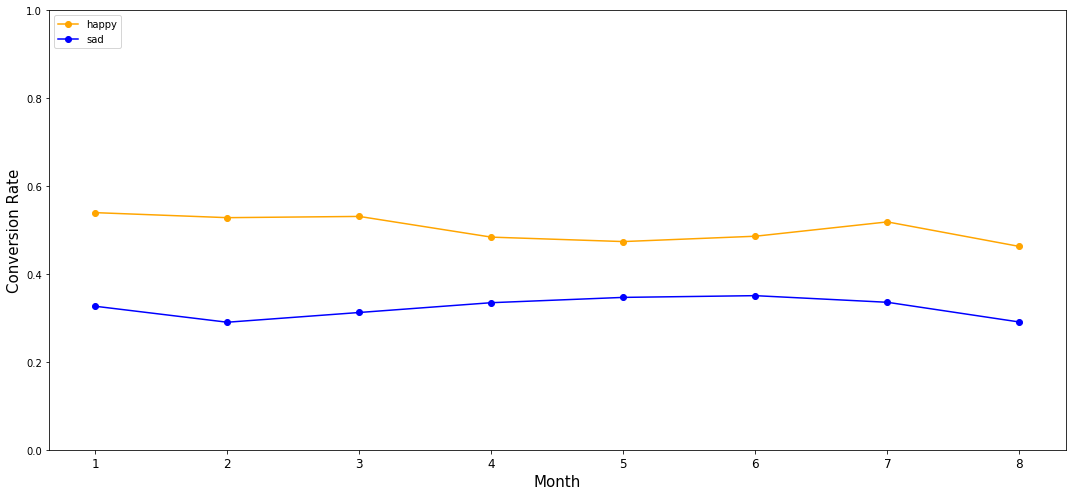

In [36]:
# plt the graphs

plt.figure(figsize=(15,7))

plt.plot('visit_date', 'clicked_button', data = happy_conversions, label = 'happy', color = 'orange', marker = 'o')
plt.plot('visit_date', 'clicked_button', data = sad_conversions, label = 'sad', color = 'blue',  marker = 'o')
plt.xticks(size = 12)
plt.xlabel('Month', size = 15)
plt.ylabel('Conversion Rate', size = 15)
plt.ylim(0,1)
plt.tight_layout()
plt.legend(loc = 'upper left')
plt.show()

We can see there is a clear gap, with the happy cat performing better in conversions over the last 8 months. There is a slight dip from March to June, but relatively in the conversion range of ~47% to ~53%. Whereas it looks like the sad cat didn't break past the ~35% conversion mark.

## Difference in Months

In [49]:
# create a pivot table to compare the changes
pivot_tbl = pd.pivot_table(eight_month, values ='clicked_button', index = eight_month['visit_date'].dt.month, columns = ['condition'],aggfunc = np.mean)
pivot_tbl

condition,happy_cat,sad_cat
visit_date,,
1,0.539735,0.326693
2,0.528302,0.290323
3,0.531120,0.312500
4,0.484000,0.334783
5,0.473896,0.346863
6,0.486056,0.350806
7,0.518657,0.335714
8,0.462810,0.290837


In [52]:
# create new variable for the difference
pivot_tbl['difference'] = pivot_tbl['happy_cat']- pivot_tbl['sad_cat']
pivot_tbl

condition,happy_cat,sad_cat,difference
visit_date,,,
1,0.539735,0.326693,0.213042
2,0.528302,0.290323,0.237979
3,0.531120,0.312500,0.218620
4,0.484000,0.334783,0.149217
5,0.473896,0.346863,0.127032
6,0.486056,0.350806,0.135249
7,0.518657,0.335714,0.182942
8,0.462810,0.290837,0.171973


Looking at the difference, we can see that after March the differnce between the Happy and Sad cat dropped quite a bit and hovered around on the average 14-17% difference. We should be cautious if we want to use these numbers as bench marks for our follow up test, so it will be depending on which month select.

# Follow up Experiment (Continued..)

Now we understand the month patterns in the data we can test out the power analysis to get the appropriate sample size and understand if our experiment performed well.

From our original experiment with the happy and sad cat the conversion rate was 38%. If we take the average of the 8 month difference and add it to the 30% we should get a baseline conversion.

In [53]:
pivot_tbl['difference'].mean()

0.17950700441183276

Approximately ~18%, so we can add that to the 38% which would be 58%. We also want to see an increase of 15% conversion rate.

In [57]:
# using the get sample size formula
get_sample_size(0.8, 0.58,0.73, 0.95)

201

Now we see our sample need 201 users to run the test. We have the results from September 2018. Let's explore the dataset.

In [71]:
# read dataset
september = pd.read_csv("september_2018.csv")

#convert to datetime
september['visit_date'] = pd.to_datetime(september['visit_date'])

In [73]:
september.groupby(['condition']).agg('mean')

,clicked_button
condition,
cat,0.601770
kitten,0.754717


The kitten landing page performed better, with a higher conversion rate at 75%. A 15% difference from the Cat photo, which is the close to the 18% average difference we had in the past.

## Logisitic Model

In [74]:
# import statsmodels.formula.api as smf

# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ clicked_button ~ condition
                                        """,
                                        data    = september)

# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.616531
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         clicked_button   No. Observations:                  219
Model:                          Logit   Df Residuals:                      217
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:                 0.02137
Time:                        20:23:03   Log-Likelihood:                -135.02
converged:                       True   LL-Null:                       -137.97
Covariance Type:            nonrobust   LLR p-value:                   0.01516
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4128      0.192      2.148      0.032       0.036       0.789
condition[T.kitten]     0.7111      0.296      2.399      0.016       0.130       1.292
=======================================================================================
"""

Our follow-up experiment was successful! Now that we pulled the correct number of data points, we can see that there is a boost by using a kitten over a cat.

# Final Overview

With our goal to increase conversions in users clicking the "Adopt today" button on a pet adoption landing page we could see how the changes affected our results. In the first scenario we changed the original sad cat, to a happy cat and we saw our conversions performed better for the test group by 18% more (total 38% conversion).

After a successful test, we decided to roll out the happy cat to the entire population. We wanted to asses if could continue testing and improve conversions, so we looked into changing the happy cat to a happy kitten. We ran the test with a smaller samples size because we were hoping for a big jump in conversions with this change. Despite our assumptions, the result was not significant and there for we had to get a large sample size.

Before continuing with our follow up we decided to let our original happy/sad cat test continue to run over the next 8 months. We did this to see the longer term affects on the original test. After 8 months we say a relatively consistent conversion for the happy cat around 48-50% - continusouly outperforming the sad cat.

After gathering more data, we had better information to improve our assumptions on the baseline conversions. Now we tested the new converison baselines and got a more appropriate sample size for our follow up kitten test. Running the improved test, our results deemed to be significant and our Kitten group outperformed our cat group witha conversion of 75%. We now have a strong foundation to gradually keep building on our results.